In [1]:
import numpy as np
import pandas as pd

from modAL.models import ActiveLearner
from modAL.uncertainty import uncertainty_sampling
from modAL.models import Committee
from modAL.disagreement import vote_entropy_sampling


from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
import sklearn.linear_model
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import precision_recall_fscore_support
import xgboost as xgb

import recordlinkage as rl

from IPython import display
from matplotlib import pyplot as plt
%matplotlib inline

In [3]:
df_uns = pd.read_csv(r'C:\Users\Invitado\Documents\Python\DS_MASTER\City_Adam_Intern\df_uns_label_img_1.csv')
df_full = pd.read_csv(r'C:\Users\Invitado\Documents\Python\DS_MASTER\City_Adam_Intern\merged_clean_df.csv')
df_full.drop('Unnamed: 0',axis=1,inplace=True)

#Manually annotated data
test_1 = rl.read_annotation_file(r'C:\Users\Invitado\Documents\Python\DS_MASTER\City_Adam_Intern\result_bnb_trip.json')
test_2 = rl.read_annotation_file(r'C:\Users\Invitado\Documents\Python\DS_MASTER\City_Adam_Intern\result_bnb_vrb.json')

In [45]:
df_uns

,ListingId_1,ListingId_2,Name_jaro_winker,Name_levenshtein_sim,Name_jaccard_sim,Name_relaxed_jaccard_sim,Name_overlap_sim,Name_containment_sim,Bedrooms_binary,Bedrooms_numerical,...,Star_rating_binary,Star_rating_numerical,Xl_picture_url_img,LaBSE_emb_LaBSE_cos,Descrp_tfidf_tf_idf_cos,Lat_Lng_geo,ids,agg_score,weights,uns_label
0,10043980,10025641,0.976471,0.941176,0.714286,0.714286,0.0,0.833333,1.0,1.0,...,1.0,1.00000,0.999709,0.936309,0.988256,0.972364,"(10043980, 10025641)",0.897852,0.829414,1.0
1,10044256,10025641,0.988235,0.970588,0.714286,0.714286,0.0,0.833333,1.0,1.0,...,1.0,1.00000,0.998886,0.999702,0.998728,0.956031,"(10044256, 10025641)",0.911078,0.851502,1.0
2,10044256,10043980,0.976471,0.941176,0.714286,0.714286,0.0,0.833333,1.0,1.0,...,1.0,1.00000,0.998843,0.936287,0.989496,0.972462,"(10044256, 10043980)",0.883966,0.806225,1.0
3,10145992,10025641,0.988235,0.970588,0.714286,0.714286,0.0,0.833333,1.0,1.0,...,1.0,1.00000,0.989987,0.845712,0.964040,0.930090,"(10145992, 10025641)",0.849651,0.748919,1.0
4,10145992,10044256,0.988235,0.970588,0.714286,0.714286,0.0,0.833333,1.0,1.0,...,1.0,1.00000,0.990425,0.847703,0.962973,0.932911,"(10145992, 10044256)",0.862754,0.770801,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44332,5315586,20757123,0.427575,0.333333,0.000000,0.166667,0.0,0.000000,0.0,0.0,...,-1.0,-1.00000,0.995385,0.797381,-1.000000,0.984002,"(5315586, 20757123)",0.238787,0.404807,0.0
44333,5315586,27795712,0.662645,0.333333,0.000000,0.125000,0.0,0.000000,0.0,0.0,...,0.0,0.69697,0.997954,0.777321,-1.000000,0.982979,"(5315586, 27795712)",0.285751,0.287747,0.0
44334,50452179,50451988,0.915705,0.769231,0.500000,0.500000,0.0,0.666667,1.0,1.0,...,0.0,0.69697,1.000000,0.976764,-1.000000,0.991118,"(50452179, 50451988)",0.706566,0.509970,1.0
44335,25853345,25433802,0.657520,0.204545,0.000000,0.000000,0.0,0.000000,0.0,0.0,...,-1.0,-1.00000,0.996721,0.932478,0.158012,0.943027,"(25853345, 25433802)",0.695347,0.491234,1.0


In [42]:

def compare(df,id_1,id_2,full =False):
    link = [x for x in df_full['listing_url'][df_full['ListingId']==id_1]]
    link_2 = [x for x in df_full['listing_url'][df_full['ListingId']==id_2]]
    
    if full == True:
    #Compare URLS
        lista = [print(x,':',y,'==',z) for x,y,z in zip(df.columns.tolist(),
                                                        df[df['ListingId'] == id_1].values.tolist()[0],
                                                        df[df['ListingId'] == id_2].values.tolist()[0])]
        return 'Full info retrieved'
    else:
        print(link[0])
        print(link_2[0])
        return 'Links retreived'
        

compare(df_full,10161202, 10161074,full=False)

https://www.airbnb.nl/rooms/10161202
https://www.airbnb.nl/rooms/10161074


'Links retreived'

In [5]:
#Take out the labeled data for making a test set 
manual_labeled = []

#Getting the Listing Ids bc the files is in index 
for x,y in test_1.links:
    tuple_1 = (df_full['ListingId'].iloc[x],df_full['ListingId'].iloc[y])
    tuple_2 = (df_full['ListingId'].iloc[y],df_full['ListingId'].iloc[x])
    manual_labeled.append([str(tuple_1),1])
    manual_labeled.append([str(tuple_2),1])
    
for x,y in test_2.links:
    tuple_1 = (df_full['ListingId'].iloc[x],df_full['ListingId'].iloc[y])
    tuple_2 = (df_full['ListingId'].iloc[y],df_full['ListingId'].iloc[x])
    manual_labeled.append([str(tuple_1),1])
    manual_labeled.append([str(tuple_2),1])
for x,y in test_1.distinct:
    tuple_1 = (df_full['ListingId'].iloc[x],df_full['ListingId'].iloc[y])
    tuple_2 = (df_full['ListingId'].iloc[y],df_full['ListingId'].iloc[x])
    manual_labeled.append([str(tuple_1),0])
    manual_labeled.append([str(tuple_2),0])
    
for x,y in test_2.distinct:
    tuple_1 = (df_full['ListingId'].iloc[x],df_full['ListingId'].iloc[y])
    tuple_2 = (df_full['ListingId'].iloc[y],df_full['ListingId'].iloc[x])
    manual_labeled.append([str(tuple_1),0])
    manual_labeled.append([str(tuple_2),0])

 #Merging to have it with the full data   
df_labeled = pd.DataFrame(manual_labeled,columns=['ids','labels'])
df_labeled
with_labels =df_uns.merge(df_labeled,on='ids',how='left')


In [15]:
#Comitee of models
def randomforest():
    clf = RandomForestClassifier(random_state=1)
    return clf
def desiciontree():
    clf= DecisionTreeClassifier(random_state=1)
    return clf
def logisticreg():
    clf = LogisticRegression(random_state=1)
    return clf
def xbg_class():
    clf = xgb.XGBClassifier()
    return clf
def svm():
    clf = SVC(probability=True)
    return clf

In [44]:
#Comitee of models
members = [randomforest,desiciontree,logisticreg,xbg_class,svm]
#List with comitee object
learner_list = list()

#Only use the data corresponding to the features to train
not_train = ['ListingId_1','ListingId_2','ids', 'agg_score', 'weights','uns_label','labels']
ids = with_labels['ids'].values
X_pool = with_labels.drop(not_train, axis=1).values
y_uns_label = with_labels['uns_label'].values
y_uns_weight = with_labels['weights'].values

#Create the test set , select the not nan values
y_test_1= with_labels['labels'].values
idx = np.argwhere(~np.isnan(y_test_1)).reshape(-1)
y_test= y_test_1[idx]
X_test = X_pool[idx]
#Eliminate from the main data variables the test data extracted
X_pool = np.delete(X_pool, np.argwhere(~np.isnan(y_test_1)), axis=0)
y_uns_label = np.delete(y_uns_label, np.argwhere(~np.isnan(y_test_1)), axis=0)
y_uns_weight = np.delete(y_uns_weight, np.argwhere(~np.isnan(y_test_1)), axis=0)
ids = np.delete(ids, np.argwhere(~np.isnan(y_test_1)), axis=0)
 
for clf in members:
    # initial training data
    #Selcting the most confident unsupervised labels for initial training
    if clf == randomforest:
        X_train = X_pool
        y_train = y_uns_label
        # initializing learner
        learner = ActiveLearner(
            estimator=clf(),
            X_training=X_train, y_training=y_train
        )
        learner_list.append(learner)
    else:
        train_idx = np.where(y_uns_weight==1)
        X_train = X_pool[train_idx]
        y_train = y_uns_label[train_idx]
        # initializing learner
        learner = ActiveLearner(
            estimator=clf(),
            X_training=X_train, y_training=y_train
        )
        learner_list.append(learner)
# assembling the committee
committee = Committee(learner_list=learner_list,query_strategy=vote_entropy_sampling)

In [ ]:
y_pred = committee.predict(X_test)
precision_recall_fscore= precision_recall_fscore_support(y_test,y_pred,average='binary',zero_division=0)

precision_scores = [precision_recall_fscore[0]]
recall_scores=  [precision_recall_fscore[1]]
f_score = [precision_recall_fscore[2]]

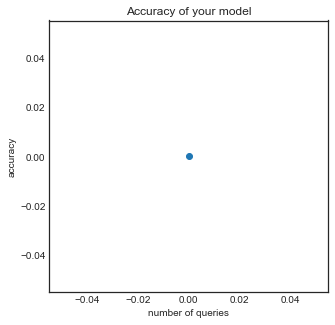

Are this two listings the same one? 1-match , 0-nonmatch, 2-more=info
https://www.airbnb.nl/rooms/14292407
https://www.airbnb.nl/rooms/1279735
Links retreived
2
[['site' 'AIRBNB']
 ['ListingId' 14292407]
 ['Name' 'ROMANTIC BRIGHT PVT STUDIO IN CITY CENTRE *****']
 ['postalcode' '1073 BW']
 ['Bedrooms' 1.0]
 ['Bathrooms' 15.0]
 ['Beds' 1.0]
 ['Person_capacity' 2]
 ['Host_first_name' 'Iago']
 ['Host_picture_url'
  'https://a0.muscache.com/im/pictures/user/c157a549-3dfe-4f8a-a97e-e5b452f70e79.jpg?aki_policy=profile_x_medium']
 ['Instant_bookable' 1]
 ['Is_new_listing' 0]
 ['Neighborhood' 'amsterdamzuid']
 ['Lat' 52.3565]
 ['Lng' 4.89848]
 ['Picture_url'
  'https://a0.muscache.com/im/pictures/miso/Hosting-14292407/original/281af6f9-2b1b-417c-a9db-8f9afc141645.jpeg?aki_policy=large']
 ['reviews_count' 138.0]
 ['Room_type_category' 'private_room']
 ['Room_type' 'Privékamer']
 ['Space_type' 'Privékamer']
 ['booking_count' 151.0]
 ['host_listings_count_hist' 2.0]
 ['kpi_capacity_more_than_4' 0

KeyboardInterrupt: Interrupted by user

In [38]:
y_pred = committee.predict(X_test)
precision_recall_fscore= precision_recall_fscore_support(y_test,y_pred,average='binary',zero_division=0)

precision_scores = [precision_recall_fscore[0]]
recall_scores=  [precision_recall_fscore[1]]
f_score = [precision_recall_fscore[2]]
new_labels = []

# query by committee
n_queries = 20
for idx in range(n_queries):
    query_idx, query_instance = committee.query(X_pool)
    
    with plt.style.context('seaborn-white'):
        plt.figure(figsize=(5, 5))
        plt.subplot(1, 1, 1)
        plt.title('Accuracy of your model')
        plt.plot(range(idx+1), precision_scores)
        plt.scatter(range(idx+1), precision_scores)
        plt.xlabel('number of queries')
        plt.ylabel('accuracy')
        display.display(plt.gcf())
        plt.close('all')
        
    print("Are this two listings the same one? 1-match , 0-nonmatch, 2-more=info")
    ids_int = [int(x) for x in ids[query_idx[0]][1:-1].split(',')]
    print(compare(df_full,ids_int[0],ids_int[1]))
    label = int(input())
    if label == 2:
        print(compare(df_full,ids_int[0],ids_int[1],full=True))
        label = int(input())  
    
    y_new = np.array([label], dtype=int)
    committee.teach(query_instance.reshape(1, -1), y_new)

    X_pool = np.delete(X_pool, query_idx, axis=0)

    y_pred = committee.predict(X_test)
    precision_recall_fscore=precision_recall_fscore_support(y_test,y_pred,average='binary',zero_division=0)

    precision_scores.append(precision_recall_fscore[0])
    recall_scores.append(precision_recall_fscore[1])
    f_score.append(precision_recall_fscore[2])
    new_labels.append([(ids_int[0],ids_int[1]),label])
    print(X_pool.shape)

In [50]:
from sklearn.metrics import precision_score
y_pred = committee.predict(X_test)
x = precision_recall_fscore_support(y_test,y_pred,average='binary',zero_division=0)


In [29]:
for x in committee:
    y_pred = x.predict(X_test)
    precision_recall_fscore= precision_recall_fscore_support(y_test,y_pred,average='binary',zero_division=0)
    print(x.get_params()['estimator'])
    break

RandomForestClassifier(random_state=1)


C:\Users\Invitado\anaconda3\lib\site-packages\sklearn\base.py:209: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  warnings.warn('From version 0.24, get_params will raise an '
